# 🌸 Floranet

---
- 902011, Moleri Andrea, a.moleri@campus.unimib.it
- 865939, Armani Filippo, f.armani1@campus.unimib.it
---

## 🎯 Domain and Objectives

The notebook you are about to read contains a project called Floranet, which aims to classify, through the use of machine learning and deep learning techniques, a dataset containing 102 classes of different flowers. In particular, the dataset used is known as the [Oxford Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html), compiled by Maria-Elena Nilsback and Andrew Zisserman. Each of the 102 classes consists of a variable number ranging from 40 to 258 images per class. The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories. The dataset is visualized using isomap with shape and colour features. Our aim is therefore to investigate the possibilities of building models in order to solve the classification task. In other words, given an image of a flower, we want to be able to correctly identify and recognize the flower in question, minimizing the margin of error as much as possible.

In [19]:
import os
from scipy.io import loadmat
import pandas as pd

# Paths
images_dir = 'Data/images'
labels_path = 'Data/imagelabels.mat'

# Load labels
labels_data = loadmat(labels_path)
labels = labels_data['labels'][0]  # Original numeric labels

# Flower names mapping from the professor's code
NAMES = [
    "Pink Primrose", "Hard-Leaved Pocket Orchid", "Canterbury Bells",
    "Sweet Pea", "English Marigold", "Tiger Lily", "Moon Orchid",
    "Bird Of Paradise", "Monkshood", "Globe Thistle", "Snapdragon",
    "Colt's Foot", "King Protea", "Spear Thistle", "Yellow Iris",
    "Globe-Flower", "Purple Coneflower", "Peruvian Lily", "Balloon Flower",
    "Giant White Arum Lily", "Fire Lily", "Pincushion Flower", "Fritillary",
    "Red Ginger", "Grape Hyacinth", "Corn Poppy", "Prince Of Wales Feathers",
    "Stemless Gentian", "Artichoke", "Sweet William", "Carnation",
    "Garden Phlox", "Love In The Mist", "Mexican Aster", "Alpine Sea Holly",
    "Ruby-Lipped Cattleya", "Cape Flower", "Great Masterwort", "Siam Tulip",
    "Lenten Rose", "Barbeton Daisy", "Daffodil", "Sword Lily", "Poinsettia",
    "Bolero Deep Blue", "Wallflower", "Marigold", "Buttercup", "Oxeye Daisy",
    "Common Dandelion", "Petunia", "Wild Pansy", "Primula", "Sunflower",
    "Pelargonium", "Bishop Of Llandaff", "Gaura", "Geranium", "Orange Dahlia",
    "Pink-Yellow Dahlia?", "Cautleya Spicata", "Japanese Anemone",
    "Black-Eyed Susan", "Silverbush", "Californian Poppy", "Osteospermum",
    "Spring Crocus", "Bearded Iris", "Windflower", "Tree Poppy", "Gazania",
    "Azalea", "Water Lily", "Rose", "Thorn Apple", "Morning Glory",
    "Passion Flower", "Lotus", "Toad Lily", "Anthurium", "Frangipani",
    "Clematis", "Hibiscus", "Columbine", "Desert-Rose", "Tree Mallow",
    "Magnolia", "Cyclamen", "Watercress", "Canna Lily", "Hippeastrum",
    "Bee Balm", "Ball Moss", "Foxglove", "Bougainvillea", "Camellia", "Mallow",
    "Mexican Petunia", "Bromelia", "Blanket Flower", "Trumpet Creeper",
    "Blackberry Lily"
]

# Create a mapping from label index to flower name
ID_NAMES = dict(zip([x for x in range(len(NAMES))], NAMES))

# Get images and pair with labels (convert numeric labels to flower names)
image_files = sorted([img for img in os.listdir(images_dir) if img.endswith('.jpg')])
flower_names = [ID_NAMES[label - 1] for label in labels[:len(image_files)]]  # Convert 1-indexed labels

data = {'image_name': image_files, 'flower_name': flower_names}

# Create DataFrame
df = pd.DataFrame(data)

Total number of images: 8189

Number of images per class (ordered by count):
Class | Petunia: 258 images
Class | Passion Flower: 251 images
Class | Wallflower: 196 images
Class | Water Lily: 194 images
Class | Watercress: 184 images
Class | Rose: 171 images
Class | Frangipani: 166 images
Class | Foxglove: 162 images
Class | Cyclamen: 154 images
Class | Lotus: 137 images
Class | Hibiscus: 131 images
Class | Sword Lily: 130 images
Class | Bougainvillea: 128 images
Class | Barbeton Daisy: 127 images
Class | Thorn Apple: 120 images
Class | Geranium: 114 images
Class | Clematis: 112 images
Class | Bishop Of Llandaff: 109 images
Class | Pink-Yellow Dahlia?: 109 images
Class | Cape Flower: 108 images
Class | Morning Glory: 107 images
Class | Anthurium: 105 images
Class | Californian Poppy: 102 images
Class | Azalea: 96 images
Class | Primula: 93 images
Class | Poinsettia: 93 images
Class | Common Dandelion: 92 images
Class | Fritillary: 91 images
Class | Camellia: 91 images
Class | Snapdragon

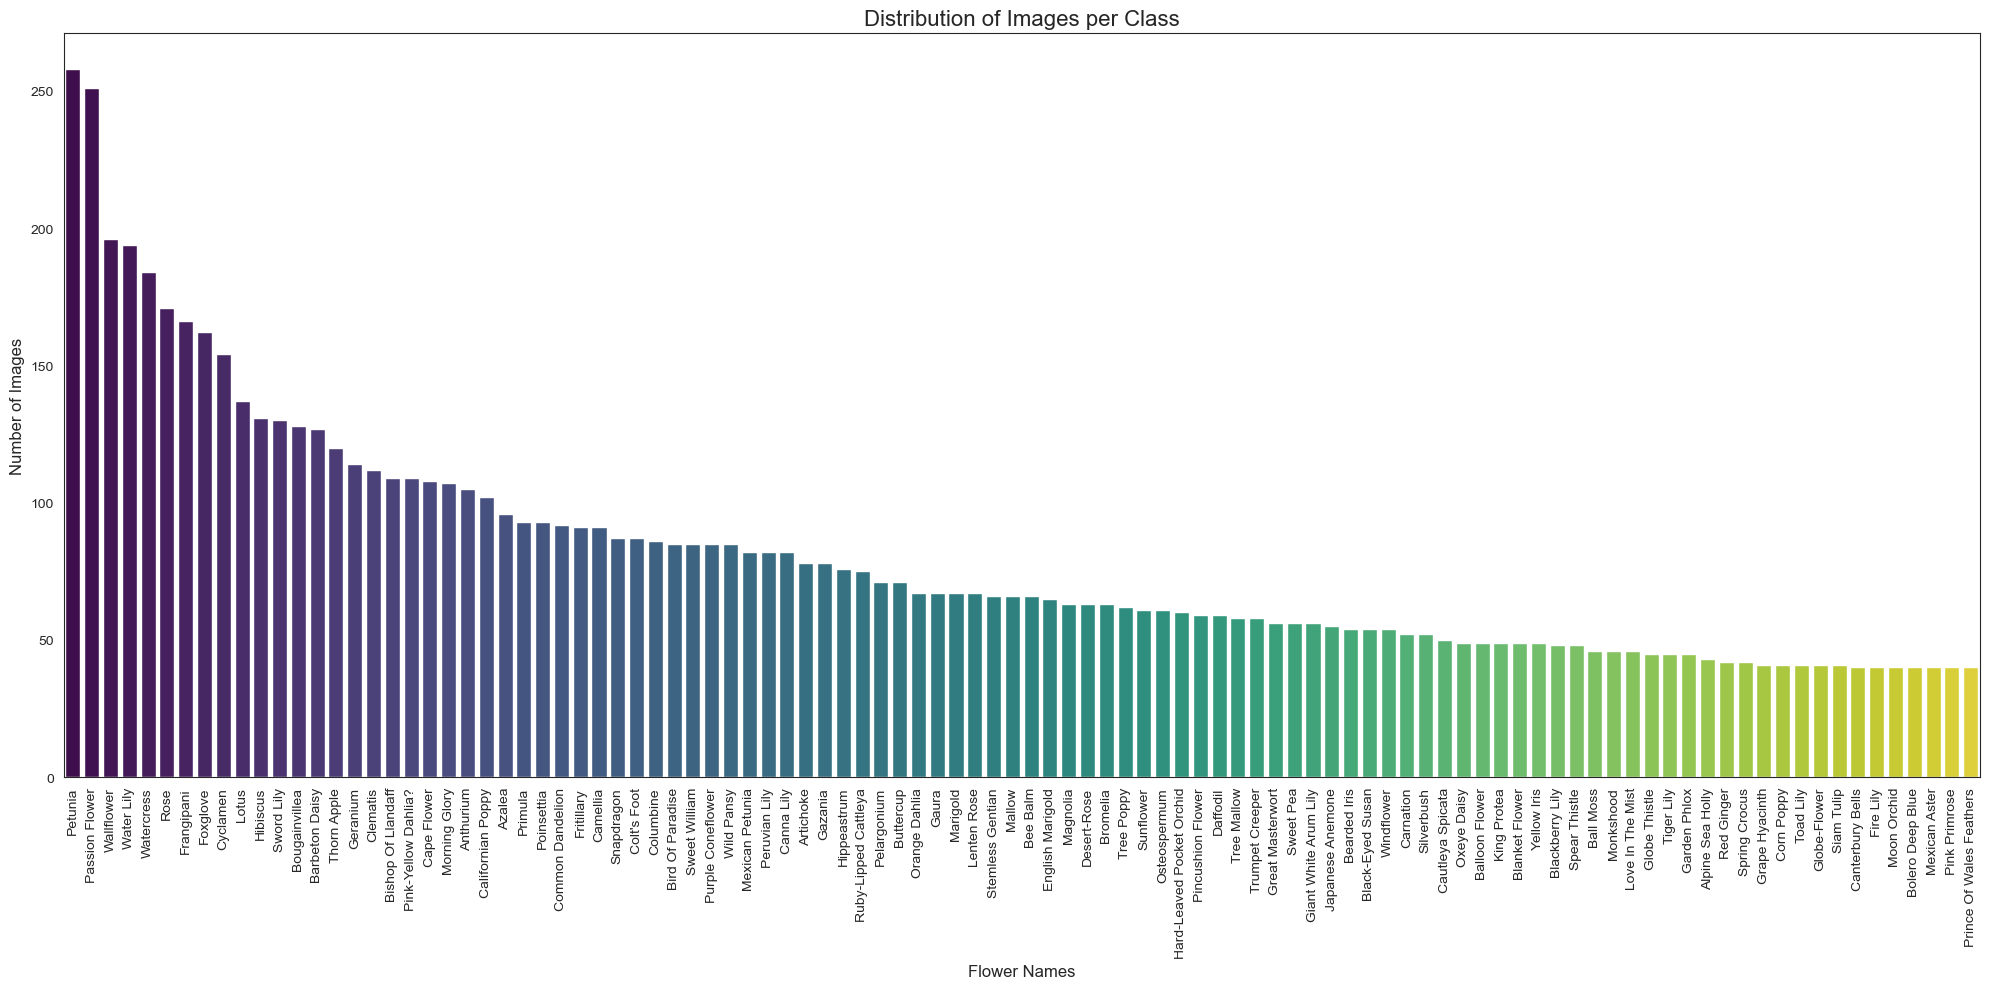

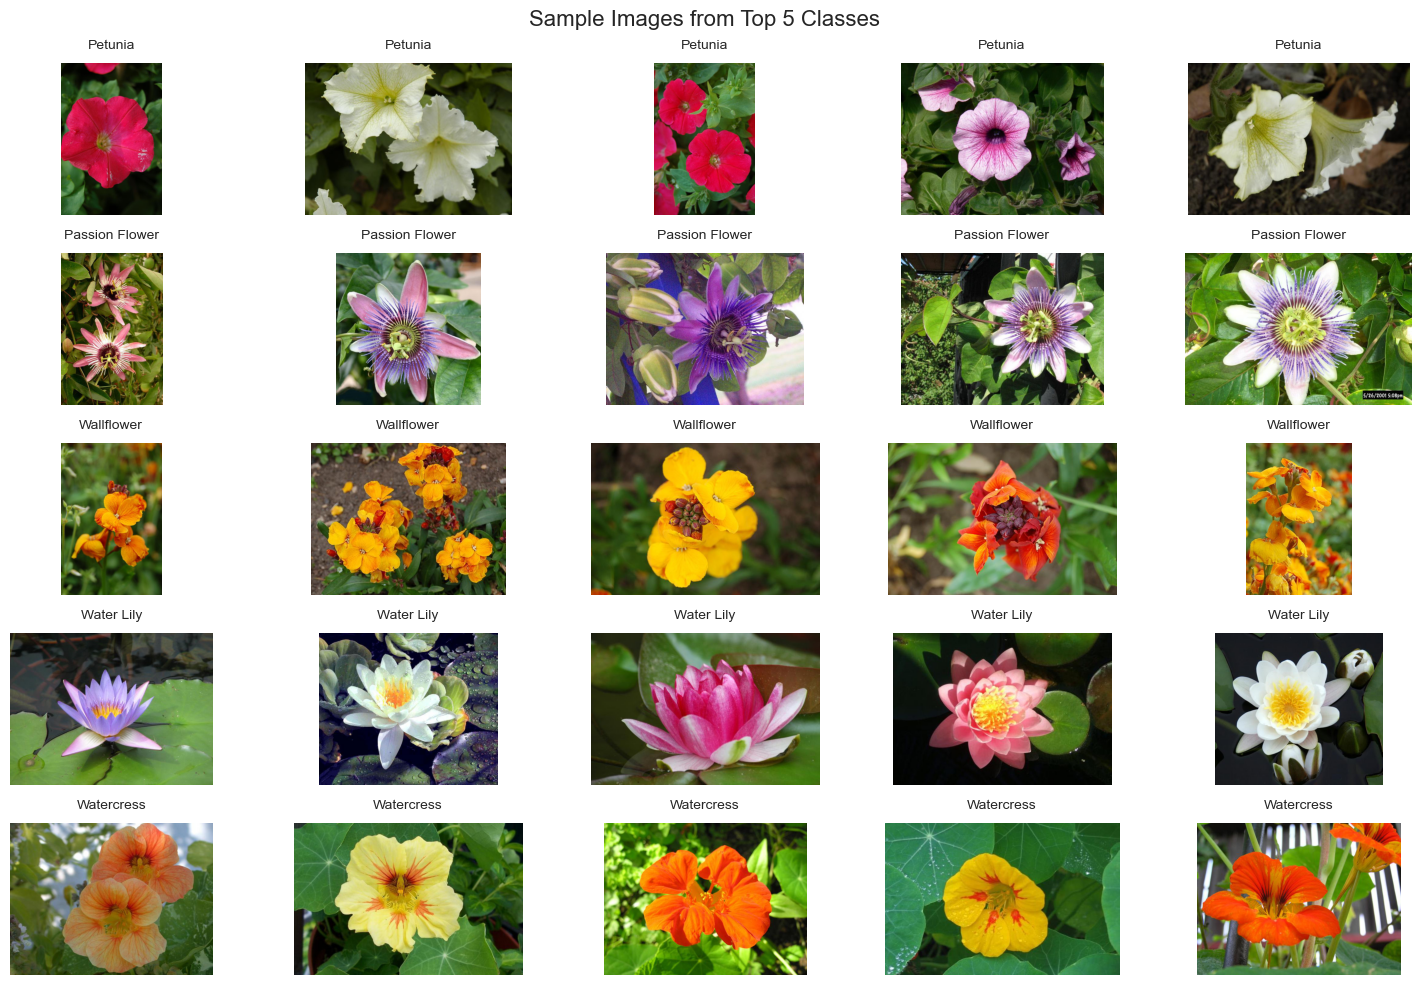

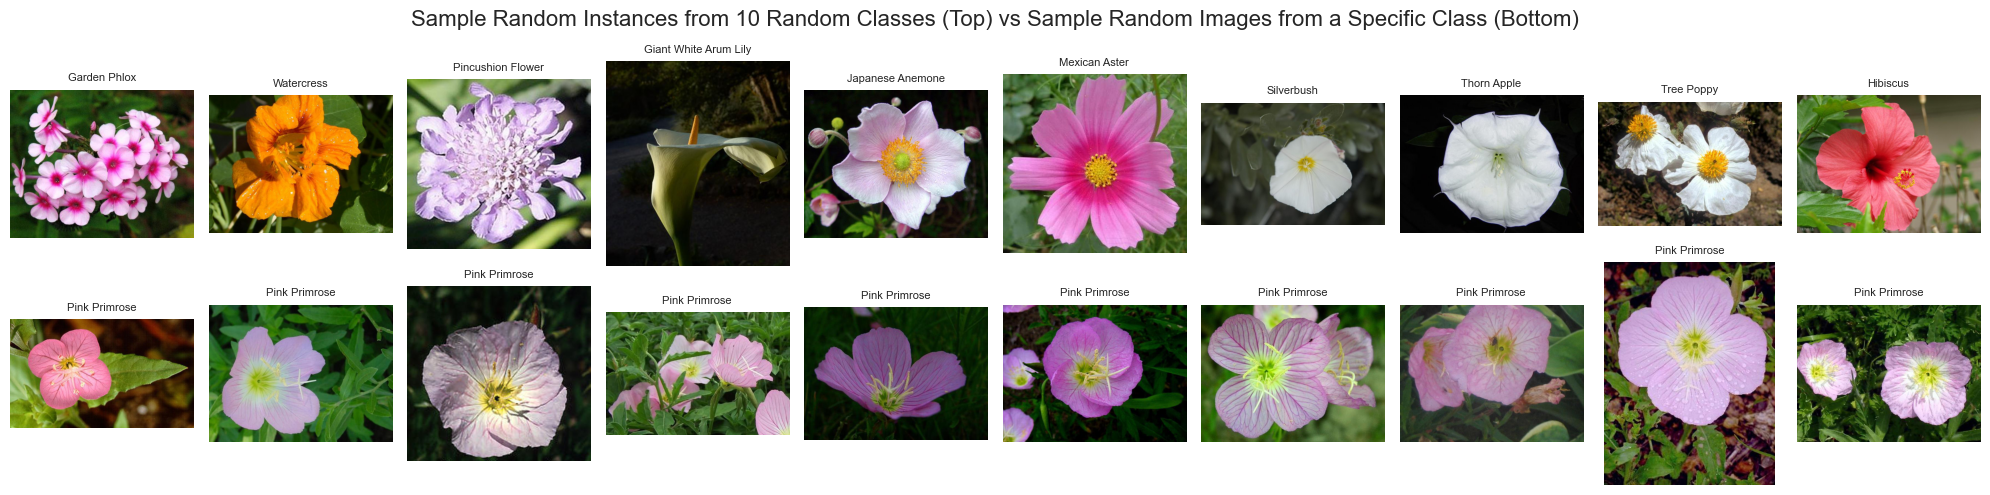

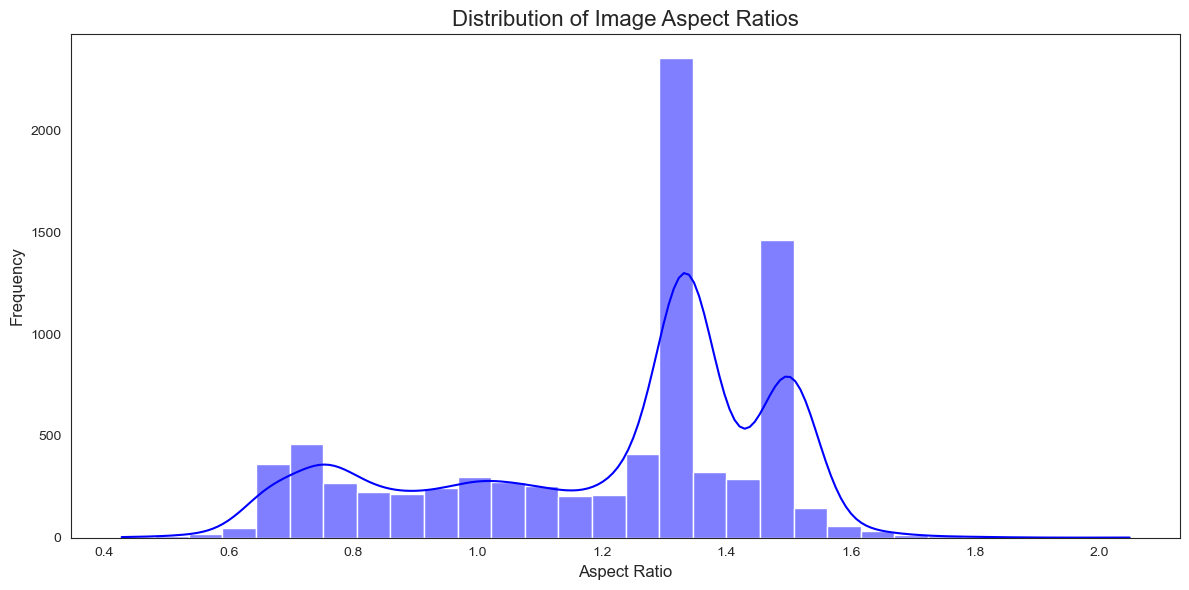


Image Dimension Statistics:
             Width       Height  Aspect Ratio
count  8189.000000  8189.000000   8189.000000
mean    630.160581   534.352058      1.210391
std      95.988254    75.453540      0.270855
min     500.000000   500.000000      0.428082
25%     501.000000   500.000000      1.000000
50%     667.000000   500.000000      1.332000
75%     699.000000   501.000000      1.398000
max    1024.000000  1168.000000      2.048000

Average number of images per class: 80.28


In [25]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

# 1. Number of total images
num_images = len(df)
print(f"Total number of images: {num_images}")

# 2. Number of images per class
images_per_class = df['flower_name'].value_counts()  # Sort by count in descending order
print("\nNumber of images per class (ordered by count):")
for flower_name, count in images_per_class.items():
    print(f"Class | {flower_name}: {count} images")

# 3. Plotting distribution of images per class
plt.figure(figsize=(20, 10))  # Increased width and height of the figure
sns.set_style("white")  # Set plot background to white
sns.barplot(x=images_per_class.index, y=images_per_class.values, palette="viridis")
plt.xlabel('Flower Names', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Images per Class', fontsize=16)
plt.xticks(rotation=90)  # Rotate for better visibility
plt.tight_layout()
plt.show()

# 4. Displaying sample images for the top 5 classes with most images
top_classes = images_per_class.head(5).index  # Top 5 most populated classes

fig, axes = plt.subplots(len(top_classes), 5, figsize=(15, 10))
for i, flower_name in enumerate(top_classes):
    sample_images = df[df['flower_name'] == flower_name].sample(5)['image_name'].values
    for j, image_name in enumerate(sample_images):
        img_path = os.path.join(images_dir, image_name)
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        # Adding the class label above each image
        axes[i, j].set_title(f"{flower_name}", fontsize=10, pad=10)
plt.suptitle('Sample Images from Top 5 Classes', fontsize=16)
plt.tight_layout()
plt.show()

# Combining 10 random images from random classes and a specific flower
random_classes = df['flower_name'].drop_duplicates().sample(10).values
class_1_images = df[df['flower_name'] == NAMES[0]].sample(10)['image_name'].values  # 'pink primrose'

fig, axes = plt.subplots(2, 10, figsize=(20, 5))
for i, flower_name in enumerate(random_classes):
    image_name = df[df['flower_name'] == flower_name].sample(1)['image_name'].values[0]
    img_path = os.path.join(images_dir, image_name)
    img = Image.open(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"{flower_name}", fontsize=8)

for i, image_name in enumerate(class_1_images):
    img_path = os.path.join(images_dir, image_name)
    img = Image.open(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title("Pink Primrose", fontsize=8)

plt.suptitle('Sample Random Instances from 10 Random Classes (Top) vs Sample Random Images from a Specific Class (Bottom)', fontsize=16)
plt.tight_layout()
plt.show()

# 5. Computing image dimensions and aspect ratio statistics
image_sizes = []
for image_name in df['image_name']:
    img_path = os.path.join(images_dir, image_name)
    with Image.open(img_path) as img:
        image_sizes.append(img.size)  # (width, height)

# Converting to DataFrame
sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
sizes_df['Aspect Ratio'] = sizes_df['Width'] / sizes_df['Height']

# 6. Plotting distribution of aspect ratios
plt.figure(figsize=(12, 6))
sns.histplot(sizes_df['Aspect Ratio'], kde=True, color='blue', bins=30)
plt.xlabel('Aspect Ratio', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Image Aspect Ratios', fontsize=16)
plt.tight_layout()
plt.show()

# Summary statistics
print("\nImage Dimension Statistics:")
print(sizes_df.describe())

# 7. Average number of images per class
avg_images_per_class = images_per_class.mean()
print(f"\nAverage number of images per class: {avg_images_per_class:.2f}")

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Rinominare la colonna 'flower_name' in 'label' e ricreare le etichette numeriche
df['label'] = df['flower_name'].map({name: idx for idx, name in enumerate(NAMES)})

# Set seed for reproducibility
seed = 42

# Splitting the dataset: 70% for training, 15% for validation, and 15% for testing
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=seed)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=seed)

# One-Hot Encoding for the labels
encoder = OneHotEncoder(sparse_output=False)  # Updated to avoid FutureWarning

# Apply One-Hot Encoding to each split
train_labels_encoded = encoder.fit_transform(train_df[['label']])
valid_labels_encoded = encoder.transform(valid_df[['label']])
test_labels_encoded = encoder.transform(test_df[['label']])

# Create a DataFrame for the one-hot encoded labels
class_columns = [f"class_{int(c)}" for c in encoder.categories_[0]]

# Concatenate the original dataframes with their respective one-hot encoded labels
train_df = pd.concat([train_df.reset_index(drop=True), pd.DataFrame(train_labels_encoded, columns=class_columns)], axis=1)
valid_df = pd.concat([valid_df.reset_index(drop=True), pd.DataFrame(valid_labels_encoded, columns=class_columns)], axis=1)
test_df = pd.concat([test_df.reset_index(drop=True), pd.DataFrame(test_labels_encoded, columns=class_columns)], axis=1)

# Get the number of images in each set
train_size = len(train_df)
valid_size = len(valid_df)
test_size = len(test_df)

# Total number of images
total_size = len(df)

# Class distribution in each set
train_class_dist = train_df['label'].value_counts().sort_index()
valid_class_dist = valid_df['label'].value_counts().sort_index()
test_class_dist = test_df['label'].value_counts().sort_index()

# Percentages of each set
train_percentage = (train_size / total_size) * 100
valid_percentage = (valid_size / total_size) * 100
test_percentage = (test_size / total_size) * 100

# Output the results
print("🗂️ Data Split Summary\n" + "="*30)

# Total dataset size
print(f"Total number of images: {total_size} images\n")

# Size of each set
print(f"Training Set: {train_size} images ({train_percentage:.2f}%)")
print(f"Validation Set: {valid_size} images ({valid_percentage:.2f}%)")
print(f"Test Set: {test_size} images ({test_percentage:.2f}%)\n")

# Class distribution in each set
print("🧑‍🏫 Class Distribution:")
print("-"*30)

# Function to display class distributions clearly
def display_class_distribution(class_dist, set_name):
    print(f"\nClass distribution in the {set_name}:")
    print(f"{'Class':<10} {'Number of Images':<20} {'Percentage':<15}")
    print("-" * 50)
    for label, count in class_dist.items():
        percentage = (count / total_size) * 100
        print(f"{label:<10} {count:<20} {percentage:<15.2f}%")
    print("\n")

# Display class distributions for each set
display_class_distribution(train_class_dist, "Training Set")
display_class_distribution(valid_class_dist, "Validation Set")
display_class_distribution(test_class_dist, "Test Set")

# Save the sets to CSV files for further use
train_df.to_csv('Data/train_set.csv', index=False)
valid_df.to_csv('Data/valid_set.csv', index=False)
test_df.to_csv('Data/test_set.csv', index=False)

# Final summary with total number of classes
print("="*30)
print(f"Total number of classes: {df['label'].nunique()}")
print(f"Classes range from 0 to {df['label'].max()}")

🗂️ Data Split Summary
Total number of images: 8189 images

Training Set: 5732 images (70.00%)
Validation Set: 1228 images (15.00%)
Test Set: 1229 images (15.01%)

🧑‍🏫 Class Distribution:
------------------------------

Class distribution in the Training Set:
Class      Number of Images     Percentage     
--------------------------------------------------
0          28                   0.34           %
1          42                   0.51           %
2          28                   0.34           %
3          39                   0.48           %
4          46                   0.56           %
5          32                   0.39           %
6          28                   0.34           %
7          59                   0.72           %
8          32                   0.39           %
9          32                   0.39           %
10         61                   0.74           %
11         61                   0.74           %
12         34                   0.42           %
13   

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

def create_model(input_shape=(224, 224, 3), num_classes=102, fine_tune_layers=100):
    """
    Crea un modello di rete neurale convoluzionale usando fine-tuning su EfficientNetB0.

    Parameters:
    - input_shape: tuple, forma dell'input (altezza, larghezza, canali)
    - num_classes: int, numero di classi per la classificazione
    - fine_tune_layers: int, numero di layers da sbloccare per il fine-tuning

    Returns:
    - model: il modello Keras compilato
    """

    # Carica EfficientNetB0 pre-addestrata su ImageNet (senza la parte superiore)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congela i primi layers (fino al numero specificato di layers)
    for layer in base_model.layers[:fine_tune_layers]:
        layer.trainable = False

    # Crea il modello
    model = models.Sequential([
        base_model,  # Inserisci il modello pre-addestrato
        layers.GlobalAveragePooling2D(),  # Pooling globale per ridurre le dimensioni
        layers.BatchNormalization(),  # Normalizzazione per stabilizzare l'allenamento
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Layer denso con regolarizzazione
        layers.Dropout(0.6),  # Dropout più aggressivo per prevenire overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer con softmax per classificazione multi-classe
    ])

    # Compila il modello
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()  # Stampa il sommario del modello

    return model

# Creazione del modello
model = create_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_2 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 512)               655872    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                      

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

# Funzione per creare il modello
def create_model(input_shape=(224, 224, 3), num_classes=102, fine_tune_layers=100):
    """
    Crea un modello di rete neurale convoluzionale usando fine-tuning su EfficientNetB0.

    Parameters:
    - input_shape: tuple, forma dell'input (altezza, larghezza, canali)
    - num_classes: int, numero di classi per la classificazione
    - fine_tune_layers: int, numero di layers da sbloccare per il fine-tuning

    Returns:
    - model: il modello Keras compilato
    """

    # Carica EfficientNetB0 pre-addestrata su ImageNet (senza la parte superiore)
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congela i primi layers (fino al numero specificato di layers)
    for layer in base_model.layers[:fine_tune_layers]:
        layer.trainable = False

    # Crea il modello
    model = models.Sequential([
        base_model,  # Inserisci il modello pre-addestrato
        layers.GlobalAveragePooling2D(),  # Pooling globale per ridurre le dimensioni
        layers.Dense(1024, activation='relu'),  # Layer denso
        layers.Dropout(0.5),  # Dropout per prevenire overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer con softmax per classificazione multi-classe
    ])

    # Compila il modello
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()  # Stampa il sommario del modello

    return model

# Creazione del modello
model = create_model()
"""

BLOCCO DI CODICE CHE ALLENA L'ARCHITETTURA:
"""
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Funzione per allenare il modello
def train_model(model, train_df, valid_df, images_dir, class_columns, batch_size=32, epochs=50, image_size=(224, 224)):
    """
    Allena il modello sul dataset fornito.

    Parameters:
    - model: il modello Keras
    - train_df: DataFrame contenente le immagini di addestramento
    - valid_df: DataFrame contenente le immagini di validazione
    - images_dir: Directory delle immagini
    - class_columns: Colonne delle etichette
    - batch_size: int, dimensione del batch
    - epochs: int, numero di epoche
    - image_size: tuple, dimensioni finali delle immagini (altezza, larghezza)

    Returns:
    - history: l'oggetto storico dell'addestramento
    """

    # Preprocessing delle immagini
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalizzazione dell'immagine
        rotation_range=20,  # Rotazione casuale
        width_shift_range=0.2,  # Traslazione orizzontale
        height_shift_range=0.2,  # Traslazione verticale
        shear_range=0.2,  # Shearing (taglio delle immagini)
        zoom_range=0.2,  # Zoom
        horizontal_flip=True,  # Riflessione orizzontale
        fill_mode='nearest')  # Modalità di riempimento

    valid_datagen = ImageDataGenerator(rescale=1./255)  # Solo normalizzazione per il validation set

    # Generatori per caricare i dati
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=images_dir,
        x_col='image_name',
        y_col=class_columns,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='raw')  # La modalità 'raw' permette di usare le etichette one-hot

    valid_generator = valid_datagen.flow_from_dataframe(
        valid_df,
        directory=images_dir,
        x_col='image_name',
        y_col=class_columns,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='raw')

    # EarlyStopping per prevenire overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Allenamento del modello
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=valid_generator,
        callbacks=[early_stopping],
        verbose=1)  # Mostra progressi durante l'allenamento

    return history

# Funzione per tracciare i grafici
def plot_training_history(history):
    # Plotting the Training and Validation Loss
    plt.figure(figsize=(12, 6))

    # Subplot per la loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Subplot per l'accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Mostrare il grafico
    plt.tight_layout()
    plt.show()

# Allenamento del modello
history = train_model(model, train_df, valid_df, images_dir, class_columns)

# Tracciare i grafici di Loss e Accuracy
plot_training_history(history)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 102)               104550    
                                                                 
Total params: 5465865 (20.85 MB)
Trainable params: 525

KeyboardInterrupt: 